In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import math
from gtda.homology import VietorisRipsPersistence
import gudhi
import ripser
from persim import plot_diagrams
from compute_rank_function_from_barcode import rank_function
import matplotlib.pyplot as plt

In [2]:
# function to generate n pts on the circle of radius r around centre (x,y) normally set to be (0,0)
def sample_circle(r, n, centre = [0,0]):
    theta = np.random.rand(n)*2*np.pi
    x = centre[0] + r * np.cos(theta)
    y = centre[1] + r * np.sin(theta)
    return np.transpose(np.array([x,y])) # output is a nx2 matrix

In [3]:
# function to add gaussian noise (of given sd) to the pts
def add_noise(pts, noise_sd=0.1):
    n,m = pts.shape
    noisy_pts = pts + np.random.normal(0,noise_sd, [n,m])
    return noisy_pts

def sample_noisy_circle(r, n, noise_sd, centre=[0,0]):
    pts = sample_circle(r,n, centre)
    noisy_circle = add_noise(pts, noise_sd)
    return noisy_circle

In [4]:
# list of noise levels to try
noises = np.linspace(0,0.25, 26)

In [7]:
noises

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25])

In [4]:
import persim
# define a function that given a distance matrix and indices of 2 groups compute the total variance
def dist_variance(dist_mat, index1, index2):
    var1 = 0
    for i in index1:
        for j in index1:
            var1 += dist_mat[i,j]
    var2 = 0
    for m in index2:
        for l in index2:
            var2 += dist_mat[m,l]
    n1 = len(index1)
    n2 = len(index2)
    tot_var = (var1/(2*n1*(n1-1))) + (var2/(2*n2*(n2-1)))
    return tot_var
def PD_permutation_test(sample1, sample2, N, dist_type="bottleneck", plot=False):
    # default distance type is bottleneck, but can have wasserstein dsitance as well
    n1 = len(sample1)
    n2 = len(sample2)
    labels = [i for i in range(n1+n2)]
    all_samples = sample1+sample2
    # compute a distance matrix between the two sets
    distances = np.zeros([n1+n2,n1+n2])
    for i in range(n1+n2):
        for j in range(i+1,n2):
            if dist_type == "bottleneck":
                dist = persim.bottleneck(np.vstack(all_samples[i]), np.vstack(all_samples[j]))
                distances[i,j] = dist
                distances[j,i] = dist
            elif dist_type == "wasserstein":
                dist = persim.wasserstein(np.vstack(all_samples[i]), np.vstack(all_samples[j]))
                distances[i,j] = dist
                distances[j,i] = dist
                
    initial_variance = dist_variance(distances, [i for i in range(n1)], [i for i in range(n1,n1+n2)])
    
    variances = []
    z = 1
    # permute
    for k in range(N-1):
        random.shuffle(labels)
        ind1 = labels[:n1]
        ind2 = labels[n1:]
        
        new_variance = dist_variance(distances, ind1, ind2)
        
        variances.append(new_variance)
        
        if new_variance <= initial_variance:
            z += 1        
     
    # compute Z/N
    p_val = z/(N+1)
    
    if plot!=False:
        # plot the distribution of the variances under permutation
        result = plt.hist(variances, bins = 10,  color='c', edgecolor='k', alpha=0.65)
        plt.axvline(initial_variance, color='k', linestyle='dashed', linewidth=1)
        min_ylim, max_ylim = plt.ylim()
        plt.text(initial_variance, max_ylim, 'Observed loss: {:.2f}'.format(initial_variance))
        plt.savefig(plot)
        plt.show()
    
    return p_val, variances

In [9]:
from compute_rank_function_from_barcode import rank_function
def total_variance(sample1, sample2):
    # takes in two lists of samples and computes their total variance
    n1 = len(sample1)
    n2 = len(sample2)
    
    # compute variance of the two samples
    # compute mean of each sample
    mean1 = sum(sample1)/n1
    mean2 = sum(sample2)/n2
    
    # compute variance
    var1 = np.sum([np.square(i-mean1) for i in sample1])/(n1-1)
    var2 = np.sum([np.square(i-mean2) for i in sample2])/(n2-1)
    
    return var1 + var2
def Permutation_test(sample1, sample2, N, plot=False):
    # takes in two lists of samples and carries out permutation testing
    # function returns p-value 
    
    n1 = len(sample1)
    n2 = len(sample2)
    labels = [1 for i in range(n1)] + [2 for i in range(n2)]
    initial_variance = total_variance(sample1, sample2)
    
    all_samples = sample1 + sample2
    
    z = 1
    variances = []
    
    # permute over N interation
    for i in range(N-1):
        random.shuffle(labels)
        ind1 = [int(u) for u, x in enumerate(labels) if x == 1]
        ind2 = [int(u) for u, x in enumerate(labels) if x == 2]
        new_sample1 = [all_samples[w] for w in ind1]
        new_sample2 = [all_samples[w] for w in ind2]
        
        new_variance = total_variance(new_sample1, new_sample2)
        # print(new_variance)
        variances.append(new_variance)
        
        if new_variance <= initial_variance:
            z += 1
    
    # compute Z/N
    p_val = z/(N+1)
    
    if plot:
        # plot the distribution of the variances under permutation
        result = plt.hist(variances, bins = 10,  color='c', edgecolor='k', alpha=0.65)
        plt.axvline(initial_variance, color='k', linestyle='dashed', linewidth=1)
        min_ylim, max_ylim = plt.ylim()
        plt.text(initial_variance, max_ylim, 'Observed loss: {:.2f}'.format(initial_variance))
        plt.show()
    
    return p_val, variances

In [5]:
from rank import rank_function as rank_function2d
from helper_functions import Compute_Rivet

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
bottleneck_pvals = [0 for i in range(26)]
wasserstein_pvals = [0 for i in range(26)]
rank1_pvals1 = [0 for i in range(26)]
rank2_pvals1 = [0 for i in range(26)]
for i in range(26):
    # for each i sample 100 each from circle and noisy circle with different variance
    circle_samples = [0 for j in range(100)]
    for j in range(100):
        circle_samples[j] = sample_circle(2,100)
        
    noisy_circle_samples = [0 for j in range(100)]
    for j in range(100):
        noisy_circle_samples[j] = sample_noisy_circle(2,100, noises[i])
        
    # compute the PD
    circle_samples_PD = [0 for i in range(100)]
    noisy_circle_samples_PD = [0 for i in range(100)]
    
    for k in range(100):
        circle_samples_PD[k] = ripser.ripser(circle_samples[k], maxdim=2)['dgms']
        noisy_circle_samples_PD[k] = ripser.ripser(noisy_circle_samples[k], maxdim=2)['dgms']
    
    bottleneck_pvals[i], var = PD_permutation_test(circle_samples_PD,noisy_circle_samples_PD, 5000, dist_type="bottleneck", plot=False)
    wasserstein_pvals[i], var = PD_permutation_test(circle_samples_PD,noisy_circle_samples_PD, 5000, dist_type="wasserstein", plot=False)
    
    # compute rank function+
    circle_samples_rank_fns = [0 for l in range(100)]
    noisy_circle_samples_rank_fns = [0 for l in range(100)]
    
    for l in range(100):
        circle_samples_rank_fns[l] = rank_function(circle_samples_PD[l], 0, 20, [0,5]) + rank_function(circle_samples_PD[l], 1, 20, [0,5])
        noisy_circle_samples_rank_fns[l] = rank_function(noisy_circle_samples_PD[l], 0, 20, [0,5]) + rank_function(noisy_circle_samples_PD[l], 1, 20, [0,5])

    rank1_pvals1[i], de = Permutation_test(circle_samples_rank_fns,noisy_circle_samples_rank_fns, 5000, plot=False)
    
    
    # compute 2 parameter rank functions
    circle_samples_ranks = [0 for p in range(100)]
    noisy_circle_samples_ranks = [0 for p in range(100)]
    
    for p in range(100):
        current = Compute_Rivet(circle_samples[p], resolution=50, dim=0, RipsMax=5)
        circle_samples_ranks[p] = rank_function2d(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
    
        current = Compute_Rivet(noisy_circle_samples[p], resolution=50, dim=0, RipsMax=5)
        noisy_circle_samples_ranks[p] = rank_function2d(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
        
    rank2_pvals1[i], dr = Permutation_test(circle_samples_ranks, noisy_circle_samples_ranks, 5000, plot=False)
    
    print(i)
    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [ ]:
plt.plot(noises, bottleneck_pvals)
plt.xlabel("noise level")
plt.ylabel("p-value")
plt.savefig("bottleneck_pvals.png")
plt.show()

plt.plot(noises, wasserstein_pvals)
plt.xlabel("noise level")
plt.ylabel("p-value")
plt.savefig("wasserstein_pvals.png")
plt.show()

plt.plot(noises, rank1_pvals1)
plt.xlabel("noise level")
plt.ylabel("p-value")
plt.savefig("rank1_pvals1.png")
plt.show()

plt.plot(noises, rank2_pvals1)
plt.xlabel("noise level")
plt.ylabel("p-value")
plt.savefig("rank2_pvals1.png")
plt.show()

In [ ]:
print(bottleneck_pvals)
print(wasserstein_pvals)
print(rank1_pvals1)
print(rank2_pvals1)


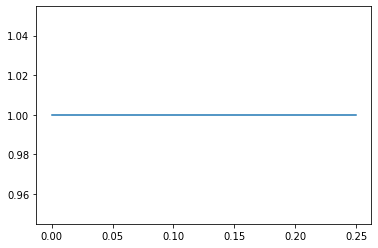

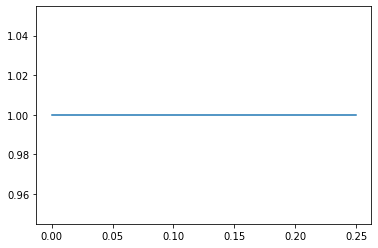

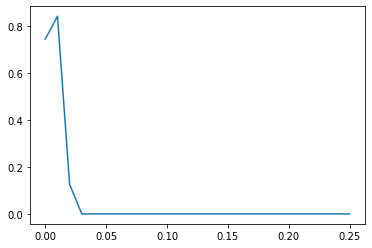

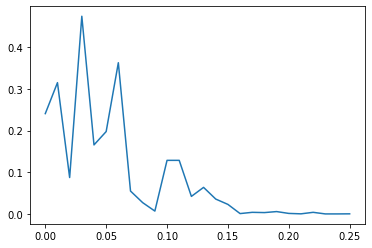

In [18]:
plt.plot(noises, bottleneck_pvals)
plt.xlabel("noise level")
plt.ylabel("p-value")
plt.savefig("bottleneck_pvals.png")
plt.show()

plt.plot(noises, wasserstein_pvals)
plt.xlabel("noise level")
plt.ylabel("p-value")
plt.savefig("wasserstein_pvals.png")
plt.show()

plt.plot(noises, rank1_pvals)
plt.xlabel("noise level")
plt.ylabel("p-value")
plt.savefig("rank1_pvals.png")
plt.show()

plt.plot(noises, rank2_pvals)
plt.xlabel("noise level")
plt.ylabel("p-value")
plt.savefig("rank2_pvals.png")
plt.show()

In [19]:
print(bottleneck_pvals)
print(wasserstein_pvals)
print(rank1_pvals)
print(rank2_pvals)


[0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016]
[0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016, 0.9998000399920016

check if the same sample gives a reasonable p-value

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/bottleneck.py:57: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/bottleneck.py:67: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+


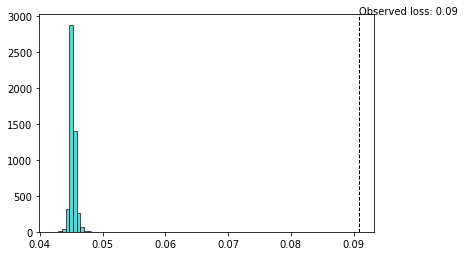

In [20]:
circle_samples = [0 for j in range(100)]
for j in range(100):
    circle_samples[j] = sample_circle(2,100)


# compute the PD
circle_samples_PD = [0 for i in range(100)]

for k in range(100):
    circle_samples_PD[k] = ripser.ripser(circle_samples[k], maxdim=2)['dgms']

bottleneck_pvals, var = PD_permutation_test(circle_samples_PD,circle_samples_PD, 5000, dist_type="bottleneck", plot="two_circle_test.png")


In [21]:
print(bottleneck_pvals)

0.9998000399920016


check if the distances are correct from a smaller sample eg 5


In [29]:
circle_samples1 = [sample_circle(2,100) for j in range(5)]
circle_samples2 = [sample_circle(2,100) for j in range(5)]
circle_pds1 = [ripser.ripser(w, maxdim=2)['dgms'] for w in circle_samples1]
circle_pds2 = [ripser.ripser(w, maxdim=2)['dgms'] for w in circle_samples2]

all_samples = circle_pds1 + circle_pds2
distances = np.zeros([10,10])
for i in range(10):
    for j in range(10):
        dist = persim.bottleneck(np.vstack(all_samples[i]), np.vstack(all_samples[j]))
        distances[i,j] = dist
        distances[j,i] = dist
print(distances)

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/bottleneck.py:57: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/bottleneck.py:67: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+


[[0.         0.15552318 0.1870808  0.10773176 0.08233792 0.29141557
  0.2161296  0.22710231 0.18086272 0.22767669]
 [0.15552318 0.         0.34260398 0.26325494 0.14370626 0.13589239
  0.37165278 0.19303721 0.33638591 0.38319987]
 [0.1870808  0.34260398 0.         0.07934904 0.19889772 0.47849637
  0.0796451  0.14956677 0.0997752  0.07175189]
 [0.10773176 0.26325494 0.07934904 0.         0.11954868 0.39914733
  0.10839784 0.132487   0.09074137 0.11994493]
 [0.08233792 0.14370626 0.19889772 0.11954868 0.         0.27959865
  0.22794652 0.16154745 0.19267964 0.23949361]
 [0.29141557 0.13589239 0.47849637 0.39914733 0.27959865 0.
  0.50754517 0.3289296  0.4722783  0.51909226]
 [0.2161296  0.37165278 0.0796451  0.10839784 0.22794652 0.50754517
  0.         0.17861557 0.05393058 0.04108948]
 [0.22710231 0.19303721 0.14956677 0.132487   0.16154745 0.3289296
  0.17861557 0.         0.1945084  0.19016266]
 [0.18086272 0.33638591 0.0997752  0.09074137 0.19267964 0.4722783
  0.05393058 0.1945084

In [30]:
dist_variance(distances, [0,1,2,3,4],[5,6,7,8,9])

0.21095484793186187

In [31]:
dist_variance(distances, [5,6,7,8,9],[0,1,2,3,4])

0.21095484793186187

In [35]:
dist_variance(distances, [5,2,7,0,4],[8,1,9,3,6])

0.21032407581806184

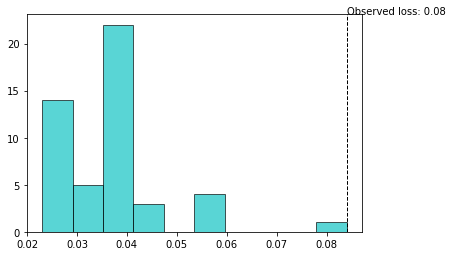

(0.9803921568627451,
 [0.03874729573726654,
  0.027665930986404418,
  0.036578568816185,
  0.03567953407764435,
  0.0362703800201416,
  0.036578568816185,
  0.025893393158912658,
  0.056777185201644896,
  0.04023783206939697,
  0.025893393158912658,
  0.04023783206939697,
  0.039646986126899715,
  0.027665930986404418,
  0.03837729394435883,
  0.03567953407764435,
  0.0362703800201416,
  0.023045819997787476,
  0.05736803114414215,
  0.032611116766929626,
  0.036578568816185,
  0.036578568816185,
  0.056777185201644896,
  0.04023783206939697,
  0.023045819997787476,
  0.032611116766929626,
  0.032611116766929626,
  0.055507493019104,
  0.03837729394435883,
  0.03567953407764435,
  0.03567953407764435,
  0.025893393158912658,
  0.032611116766929626,
  0.025893393158912658,
  0.04023783206939697,
  0.03874729573726654,
  0.023045819997787476,
  0.036578568816185,
  0.036578568816185,
  0.025893393158912658,
  0.08400171399116516,
  0.027665930986404418,
  0.04360513687133789,
  0.0276659

In [34]:
PD_permutation_test(circle_pds1, circle_pds2, 50, dist_type="bottleneck", plot="trial_pd_shuffle.png")


In [36]:
labels = [i for i in range(10)]
n1=5
N=50
variances = []
z = 1
initial_variance = dist_variance(distances, [0,1,2,3,4],[5,6,7,8,9])
for k in range(N-1):
    random.shuffle(labels)
    ind1 = labels[:n1]
    ind2 = labels[n1:]
    new_variance = dist_variance(distances, ind1, ind2)
    print(new_variance)
    variances.append(new_variance)
    if new_variance <= initial_variance:
            z += 1 

0.23099710196256637
0.21088336259126664
0.2186546728014946
0.2295456901192665
0.22407673597335814
0.21598134189844131
0.22150414884090425
0.20010271668434143
0.2001742020249367
0.22226325869560243
0.22121509313583373
0.21450567245483398
0.20850479900836943
0.198668996989727
0.20762133449316025
0.1710845410823822
0.22407673597335814
0.2170543074607849
0.21341591328382492
0.2170543074607849
0.22545104771852492
0.22586649358272554
0.2243119388818741
0.2227115735411644
0.20593558847904203
0.2309971019625664
0.20593558847904203
0.2293196365237236
0.21928544491529467
0.20956196188926696
0.19514717161655426
0.1796472981572151
0.18891519904136658
0.22794532477855683
0.22586649358272554
0.2295456901192665
0.21928544491529464
0.2275439590215683
0.2170543074607849
0.20956196188926696
0.19813958555459976
0.2237422212958336
0.21734650433063507
0.13983133137226106
0.2252863183617592
0.22541968673467636
0.22897597253322602
0.21032407581806184
0.20956196188926696


In [38]:
initial_variance
print(variances)

[0.23099710196256637, 0.21088336259126664, 0.2186546728014946, 0.2295456901192665, 0.22407673597335814, 0.21598134189844131, 0.22150414884090425, 0.20010271668434143, 0.2001742020249367, 0.22226325869560243, 0.22121509313583373, 0.21450567245483398, 0.20850479900836943, 0.198668996989727, 0.20762133449316025, 0.1710845410823822, 0.22407673597335814, 0.2170543074607849, 0.21341591328382492, 0.2170543074607849, 0.22545104771852492, 0.22586649358272554, 0.2243119388818741, 0.2227115735411644, 0.20593558847904203, 0.2309971019625664, 0.20593558847904203, 0.2293196365237236, 0.21928544491529467, 0.20956196188926696, 0.19514717161655426, 0.1796472981572151, 0.18891519904136658, 0.22794532477855683, 0.22586649358272554, 0.2295456901192665, 0.21928544491529464, 0.2275439590215683, 0.2170543074607849, 0.20956196188926696, 0.19813958555459976, 0.2237422212958336, 0.21734650433063507, 0.13983133137226106, 0.2252863183617592, 0.22541968673467636, 0.22897597253322602, 0.21032407581806184, 0.2095619

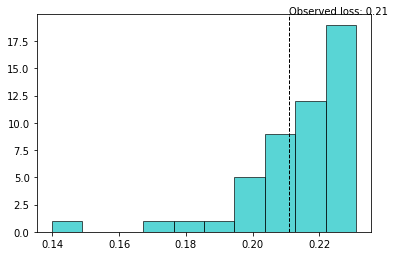

In [39]:
    # plot the distribution of the variances under permutation
    result = plt.hist(variances, bins = 10,  color='c', edgecolor='k', alpha=0.65)
    plt.axvline(initial_variance, color='k', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(initial_variance, max_ylim, 'Observed loss: {:.2f}'.format(initial_variance))
    plt.show()

In [51]:
def PD_permutation_test(sample1, sample2, N, dist_type="bottleneck", plot=False):
    # default distance type is bottleneck, but can have wasserstein dsitance as well
    n1 = len(sample1)
    n2 = len(sample2)
    labels = [i for i in range(n1+n2)]
    all_samples = sample1+sample2
    # compute a distance matrix between the two sets
    distances = np.zeros([n1+n2,n1+n2])
    if dist_type == "bottleneck":
        for i in range(n1+n2):
            for j in range(i+1,n1+n2):
                    dist = persim.bottleneck(np.vstack(all_samples[i]), np.vstack(all_samples[j]))
                    distances[i,j] = dist
                    distances[j,i] = dist
    elif dist_type == "wasserstein":
        for i in range(n1+n2):
            for j in range(i+1,n1+n2):
                dist = persim.wasserstein(np.vstack(all_samples[i]), np.vstack(all_samples[j]))
                distances[i,j] = dist
                distances[j,i] = dist
    #print(distances)
    
    initial_variance = dist_variance(distances, [i for i in range(n1)], [i for i in range(n1,n1+n2)])
    
    variances = []
    z = 1
    # permute
    for k in range(N-1):
        random.shuffle(labels)
        #print(labels)
        ind1 = labels[:n1]
        ind2 = labels[n1:]
        
        new_variance = dist_variance(distances, ind1, ind2)
        #print(new_variance)
        variances.append(new_variance)
        
        if new_variance <= initial_variance:
            z += 1        
     
    # compute Z/N
    p_val = z/(N+1)
    
    if plot!=False:
        # plot the distribution of the variances under permutation
        result = plt.hist(variances, bins = 10,  color='c', edgecolor='k', alpha=0.65)
        plt.axvline(initial_variance, color='k', linestyle='dashed', linewidth=1)
        min_ylim, max_ylim = plt.ylim()
        plt.text(initial_variance, max_ylim, 'Observed loss: {:.2f}'.format(initial_variance))
        plt.savefig(plot)
        plt.show()
    
    return p_val, variances

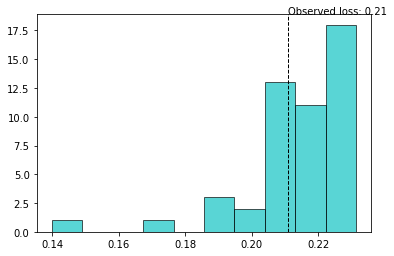

(0.35294117647058826,
 [0.19813958555459976,
  0.21928544491529464,
  0.2170543074607849,
  0.2092182978987694,
  0.2271285131573677,
  0.21032944768667222,
  0.2218478128314018,
  0.22586649358272554,
  0.2249426543712616,
  0.21032944768667222,
  0.21148261278867722,
  0.22239098995923995,
  0.22150414884090425,
  0.2249426543712616,
  0.2108833625912666,
  0.1901000201702118,
  0.22545104771852492,
  0.2240858852863312,
  0.22570176422595978,
  0.13983133137226106,
  0.20865198224782944,
  0.21450567245483398,
  0.1710845410823822,
  0.22150414884090425,
  0.23141254782676696,
  0.20941109210252762,
  0.22570176422595978,
  0.20010271668434143,
  0.21148261278867722,
  0.22121509313583373,
  0.2218478128314018,
  0.21598134189844131,
  0.21768507957458497,
  0.20956196188926696,
  0.1901000201702118,
  0.22567710131406782,
  0.2240858852863312,
  0.22586649358272554,
  0.21088336259126664,
  0.22586649358272554,
  0.23065343797206878,
  0.2141620084643364,
  0.2237422212958336,
  0.

In [52]:
PD_permutation_test(circle_pds1, circle_pds2, 50, dist_type="bottleneck", plot="trial_pd_shuffle.png")


### recompute the biparameter rank functions


In [10]:
rank2_pvals = [0 for i in range(26)]
for i in range(26):
    # for each i sample 100 each from circle and noisy circle with different variance
    circle_samples = [0 for j in range(100)]
    for j in range(100):
        circle_samples[j] = sample_circle(2,100)
        
    noisy_circle_samples = [0 for j in range(100)]
    for j in range(100):
        noisy_circle_samples[j] = sample_noisy_circle(2,100, noises[i])
        
    
    # compute 2 parameter rank functions
    circle_samples_ranks = [0 for p in range(100)]
    noisy_circle_samples_ranks = [0 for p in range(100)]
    
    for p in range(100):
        current = Compute_Rivet(circle_samples[p], resolution=50, dim=0, RipsMax=5)
        circle_samples_ranks[p] = rank_function2d(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
    
        current = Compute_Rivet(noisy_circle_samples[p], resolution=50, dim=0, RipsMax=5)
        noisy_circle_samples_ranks[p] = rank_function2d(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
        
    rank2_pvals[i], dr = Permutation_test(circle_samples_ranks, noisy_circle_samples_ranks, 5000, plot=False)
    
    print([i,rank2_pvals])
    
    

[0, [0.5724855028994201, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[1, [0.5724855028994201, 0.356128774245151, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[2, [0.5724855028994201, 0.356128774245151, 0.5118976204759048, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[3, [0.5724855028994201, 0.356128774245151, 0.5118976204759048, 0.09978004399120176, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[4, [0.5724855028994201, 0.356128774245151, 0.5118976204759048, 0.09978004399120176, 0.028994201159768047, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[5, [0.5724855028994201, 0.356128774245151, 0.5118976204759048, 0.09978004399120176, 0.028994201159768047, 0.0649870025994801, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[6, [0.5724855028994201, 0.356128774245151, 0.5118976204759048, 0.09978004399120176, 0.028994201159768047, 0.0649870025994801, 0.05798840

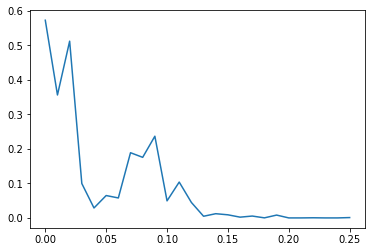

In [11]:
plt.plot(noises, rank2_pvals)

In [12]:
print(rank2_pvals)

[0.5724855028994201, 0.356128774245151, 0.5118976204759048, 0.09978004399120176, 0.028994201159768047, 0.0649870025994801, 0.05798840231953609, 0.1889622075584883, 0.17556488702259548, 0.236752649470106, 0.049590081983603276, 0.10397920415916817, 0.04499100179964007, 0.004999000199960008, 0.012397520495900819, 0.009198160367926415, 0.0023995200959808036, 0.005598880223955209, 0.0003999200159968006, 0.008398320335932814, 0.0001999600079984003, 0.0001999600079984003, 0.0005998800239952009, 0.0001999600079984003, 0.0001999600079984003, 0.0011997600479904018]


## Another biparameter rank function

In [10]:
noises = np.linspace(0,0.25, 26)
rank2_pvals = [0 for i in range(26)]
for i in range(26):
    # for each i sample 100 each from circle and noisy circle with different variance
    circle_samples = [0 for j in range(100)]
    for j in range(100):
        circle_samples[j] = sample_circle(2,100)
        
    noisy_circle_samples = [0 for j in range(100)]
    for j in range(100):
        noisy_circle_samples[j] = sample_noisy_circle(2,100, noises[i])
        
    
    # compute 2 parameter rank functions
    circle_samples_ranks = [0 for p in range(100)]
    noisy_circle_samples_ranks = [0 for p in range(100)]
    
    for p in range(100):
        current = Compute_Rivet(circle_samples[p], resolution=50, dim=0, RipsMax=5)
        circle_samples_ranks[p] = rank_function2d(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
    
        current = Compute_Rivet(noisy_circle_samples[p], resolution=50, dim=0, RipsMax=5)
        noisy_circle_samples_ranks[p] = rank_function2d(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
        
    rank2_pvals[i], dr = Permutation_test(circle_samples_ranks, noisy_circle_samples_ranks, 5000, plot=False)
    
    print([i,rank2_pvals[i]])
    
    

[0, 0.31073785242951407]
[1, 0.35032993401319734]
[2, 0.16116776644671066]
[3, 0.0597880423915217]
[4, 0.5518896220755849]
[5, 0.2663467306538692]
[6, 0.11437712457508498]
[7, 0.13917216556688664]
[8, 0.04459108178364327]
[9, 0.05638872225554889]
[10, 0.0013997200559888023]
[11, 0.005398920215956809]
[12, 0.023595280943811237]
[13, 0.07938412317536493]
[14, 0.0003999200159968006]
[15, 0.027994401119776045]
[16, 0.02519496100779844]
[17, 0.0005998800239952009]
[18, 0.009998000399920015]
[19, 0.0023995200959808036]
[20, 0.0001999600079984003]
[21, 0.0021995600879824036]
[22, 0.001999600079984003]
[23, 0.0001999600079984003]
[24, 0.0005998800239952009]
[25, 0.0001999600079984003]


In [11]:
print(rank2_pvals)

[0.31073785242951407, 0.35032993401319734, 0.16116776644671066, 0.0597880423915217, 0.5518896220755849, 0.2663467306538692, 0.11437712457508498, 0.13917216556688664, 0.04459108178364327, 0.05638872225554889, 0.0013997200559888023, 0.005398920215956809, 0.023595280943811237, 0.07938412317536493, 0.0003999200159968006, 0.027994401119776045, 0.02519496100779844, 0.0005998800239952009, 0.009998000399920015, 0.0023995200959808036, 0.0001999600079984003, 0.0021995600879824036, 0.001999600079984003, 0.0001999600079984003, 0.0005998800239952009, 0.0001999600079984003]


copy from here

In [12]:
noises = np.linspace(0,0.25, 26)
rank2_pvals = [0 for i in range(26)]
for i in range(26):
    # for each i sample 100 each from circle and noisy circle with different variance
    circle_samples = [0 for j in range(100)]
    for j in range(100):
        circle_samples[j] = sample_circle(2,100)
        
    noisy_circle_samples = [0 for j in range(100)]
    for j in range(100):
        noisy_circle_samples[j] = sample_noisy_circle(2,100, noises[i])
        
    
    # compute 2 parameter rank functions
    circle_samples_ranks = [0 for p in range(100)]
    noisy_circle_samples_ranks = [0 for p in range(100)]
    
    for p in range(100):
        current = Compute_Rivet(circle_samples[p], resolution=50, dim=0, RipsMax=5)
        circle_samples_ranks[p] = rank_function2d(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
    
        current = Compute_Rivet(noisy_circle_samples[p], resolution=50, dim=0, RipsMax=5)
        noisy_circle_samples_ranks[p] = rank_function2d(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
        
    rank2_pvals[i], dr = Permutation_test(circle_samples_ranks, noisy_circle_samples_ranks, 5000, plot=False)
    
    print([i,rank2_pvals[i]])
    
    

[0, 0.21215756848630274]
[1, 0.7812437512497501]
[2, 0.1861627674465107]
[3, 0.20655868826234752]
[4, 0.2463507298540292]
[5, 0.6740651869626075]
[6, 0.18156368726254749]
[7, 0.2855428914217157]
[8, 0.1259748050389922]
[9, 0.0623875224955009]
[10, 0.016596680663867228]
[11, 0.01759648070385923]
[12, 0.07278544291141771]
[13, 0.021995600879824034]
[14, 0.009598080383923215]
[15, 0.006998600279944011]
[16, 0.0003999200159968006]
[17, 0.0061987602479504095]
[18, 0.0009998000399920016]
[19, 0.001799640071985603]
[20, 0.0001999600079984003]
[21, 0.0021995600879824036]
[22, 0.0005998800239952009]
[23, 0.0003999200159968006]
[24, 0.0013997200559888023]
[25, 0.0001999600079984003]


In [13]:
print(rank2_pvals)

[0.21215756848630274, 0.7812437512497501, 0.1861627674465107, 0.20655868826234752, 0.2463507298540292, 0.6740651869626075, 0.18156368726254749, 0.2855428914217157, 0.1259748050389922, 0.0623875224955009, 0.016596680663867228, 0.01759648070385923, 0.07278544291141771, 0.021995600879824034, 0.009598080383923215, 0.006998600279944011, 0.0003999200159968006, 0.0061987602479504095, 0.0009998000399920016, 0.001799640071985603, 0.0001999600079984003, 0.0021995600879824036, 0.0005998800239952009, 0.0003999200159968006, 0.0013997200559888023, 0.0001999600079984003]


In [14]:
noises = np.linspace(0,0.25, 26)
rank2_pvals = [0 for i in range(26)]
for i in range(26):
    # for each i sample 100 each from circle and noisy circle with different variance
    circle_samples = [0 for j in range(100)]
    for j in range(100):
        circle_samples[j] = sample_circle(2,100)
        
    noisy_circle_samples = [0 for j in range(100)]
    for j in range(100):
        noisy_circle_samples[j] = sample_noisy_circle(2,100, noises[i])
        
    
    # compute 2 parameter rank functions
    circle_samples_ranks = [0 for p in range(100)]
    noisy_circle_samples_ranks = [0 for p in range(100)]
    
    for p in range(100):
        current = Compute_Rivet(circle_samples[p], resolution=50, dim=0, RipsMax=5)
        circle_samples_ranks[p] = rank_function2d(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
    
        current = Compute_Rivet(noisy_circle_samples[p], resolution=50, dim=0, RipsMax=5)
        noisy_circle_samples_ranks[p] = rank_function2d(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
        
    rank2_pvals[i], dr = Permutation_test(circle_samples_ranks, noisy_circle_samples_ranks, 5000, plot=False)
    
    print([i,rank2_pvals[i]])
    
    

[0, 0.3635272945410918]
[1, 0.6038792241551689]
[2, 0.09118176364727054]
[3, 0.20675864827034593]
[4, 0.484503099380124]
[5, 0.4375124975004999]
[6, 0.0007998400319936012]
[7, 0.13897220555888823]
[8, 0.09038192361527694]
[9, 0.027394521095780843]
[10, 0.05318936212757448]
[11, 0.007398520295940812]
[12, 0.0027994401119776045]
[13, 0.008398320335932814]
[14, 0.014597080583883223]
[15, 0.002999400119976005]
[16, 0.001999600079984003]
[17, 0.05298940211957608]
[18, 0.005598880223955209]
[19, 0.0003999200159968006]
[20, 0.0001999600079984003]
[21, 0.0001999600079984003]
[22, 0.0001999600079984003]
[23, 0.0015996800639872025]
[24, 0.0015996800639872025]
[25, 0.0001999600079984003]


In [15]:
print(rank2_pvals)

[0.3635272945410918, 0.6038792241551689, 0.09118176364727054, 0.20675864827034593, 0.484503099380124, 0.4375124975004999, 0.0007998400319936012, 0.13897220555888823, 0.09038192361527694, 0.027394521095780843, 0.05318936212757448, 0.007398520295940812, 0.0027994401119776045, 0.008398320335932814, 0.014597080583883223, 0.002999400119976005, 0.001999600079984003, 0.05298940211957608, 0.005598880223955209, 0.0003999200159968006, 0.0001999600079984003, 0.0001999600079984003, 0.0001999600079984003, 0.0015996800639872025, 0.0015996800639872025, 0.0001999600079984003]


In [16]:
rank2_pvals = [0 for i in range(26)]
for i in range(26):
    # for each i sample 100 each from circle and noisy circle with different variance
    circle_samples = [0 for j in range(100)]
    for j in range(100):
        circle_samples[j] = sample_circle(2,100)
        
    noisy_circle_samples = [0 for j in range(100)]
    for j in range(100):
        noisy_circle_samples[j] = sample_noisy_circle(2,100, noises[i])
        
    
    # compute 2 parameter rank functions
    circle_samples_ranks = [0 for p in range(100)]
    noisy_circle_samples_ranks = [0 for p in range(100)]
    
    for p in range(100):
        current = Compute_Rivet(circle_samples[p], resolution=50, dim=0, RipsMax=5)
        circle_samples_ranks[p] = rank_function2d(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
    
        current = Compute_Rivet(noisy_circle_samples[p], resolution=50, dim=0, RipsMax=5)
        noisy_circle_samples_ranks[p] = rank_function2d(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
        
    rank2_pvals[i], dr = Permutation_test(circle_samples_ranks, noisy_circle_samples_ranks, 5000, plot=False)
    
    print([i,rank2_pvals[i]])
    
    

[0, 0.1803639272145571]
[1, 0.3061387722455509]
[2, 0.5566886622675465]
[3, 0.7440511897620475]
[4, 0.12917416516696661]
[5, 0.21155768846230755]
[6, 0.14197160567886422]
[7, 0.1307738452309538]
[8, 0.015396920615876825]
[9, 0.04099180163967207]
[10, 0.0621875624875025]
[11, 0.1959608078384323]
[12, 0.03099380123975205]
[13, 0.01259748050389922]
[14, 0.03199360127974405]
[15, 0.012397520495900819]
[16, 0.002599480103979204]
[17, 0.0001999600079984003]
[18, 0.007198560287942412]
[19, 0.0001999600079984003]
[20, 0.0003999200159968006]
[21, 0.0005998800239952009]
[22, 0.0001999600079984003]
[23, 0.0001999600079984003]
[24, 0.0001999600079984003]
[25, 0.0001999600079984003]


In [17]:
print(rank2_pvals)

[0.1803639272145571, 0.3061387722455509, 0.5566886622675465, 0.7440511897620475, 0.12917416516696661, 0.21155768846230755, 0.14197160567886422, 0.1307738452309538, 0.015396920615876825, 0.04099180163967207, 0.0621875624875025, 0.1959608078384323, 0.03099380123975205, 0.01259748050389922, 0.03199360127974405, 0.012397520495900819, 0.002599480103979204, 0.0001999600079984003, 0.007198560287942412, 0.0001999600079984003, 0.0003999200159968006, 0.0005998800239952009, 0.0001999600079984003, 0.0001999600079984003, 0.0001999600079984003, 0.0001999600079984003]
